# Процесс построения адекватной модели. Визуализация кривых остатков

## Описание лабораторной

Основная цель проектов, связанных с ML – разработать качественную и надежную модель, которую можно использовать на новых данных.

Для того, чтобы убедиться, что модель адекватная, необходимо, чтобы:

1. данные, на которых обучается модель, были парвильно и корректно предобработаны;
2. метрики качества показывали хорошие результаты;
3. сами предсказания были корректными и отвечали нашим требованиям.
На последних двух пунктах остановимся поподробнее.

Цель лабораторной работы – создать шаблон обучения модели, а также проверки ее предсказаний при помощи визуализации графика остатков

Для будущих лабораторных работ нам нужно будет строить модели, и было бы хорошо, чтобы такой шаблон появился как можно раньше

Представим, что у нас уже имеется предобработанный датасет. Мы решали задачу регрессии: предсказывали стоимость дома по его характеристикам (то есть объектом в датасете являются параметры дома, а целевым значением – его стоимость).

Загрузим набор данных о стоимости домов при помощи следующей функции:

`from sklearn.datasets import fetch_california_housing`

Количество строк, которое возвращается, указывать не нужно, лучше возвращать датасет в виде объекта pd.DataFrame:

`fetch_california_housing(as_frame=True)`

Данная функция возвращает словарь, в котором под ключом 'data' хранится матрица объект-признак, а под 'target' – список целевых значений.

1. Разделите данные на обучающую и тестирующую выборки. Обоснуйте объем тестирующей выборки.
2. Выберите модель ML, которой можно решить данную задачу. Определите набор метрик, которые позволят объективно оценить качество модели. Обоснуйте свой выбор (модели и метрик).
3. При помощи библиотеки optuna сгенерируйте функционал по подбору гиперпараметров выбранной модели. Сформируйте сетку гиперпараметров, а также запустите обучение.
4. Получите предсказание на обученной модели.
5. Постройте графики остатков (Predicted vs Actual Plot и Residuals vs Predicted Plot) для предсказанных данных и истинных значений. Попробуйте проинтерпритировать полученные результаты.

## Реализация

### Импорт библиотек

In [82]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error, mean_squared_error

import numpy as np

import optuna

### Загрузка данных

In [83]:
data = fetch_california_housing(as_frame=True)

In [46]:
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [84]:
X = data.data
y = data.target

### Разделите данные на обучающую и тестирующую выборки. Обоснуйте объем тестирующей выборки.

Я поделю данные на обучающую и тестовую выборку в пропорции 70 на 30, почему так? У нас 20640 записей -> мы можем отдать небольшую часть в тестовую выборку чтобы проверить обобщающую способность нашей модели. 70% данных будет достаточно для обучения нашей модели.

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [58]:
df = X_train.copy()
df['MedHouseVal'] = y_train.copy()

### Выберите модель ML, которой можно решить данную задачу. Определите набор метрик, которые позволят объективно оценить качество модели. Обоснуйте свой выбор (модели и метрик).

Для выбора модели мы возьмем три критерия:

1) Как признаки связаны с зависимой переменной
2) Как признаки взаимосвязаны между собой
3) Нормализация данных

#### Взаимосвязь между придикторами и таргетом

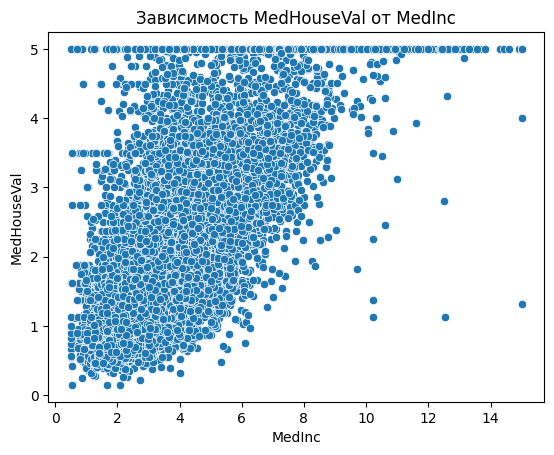

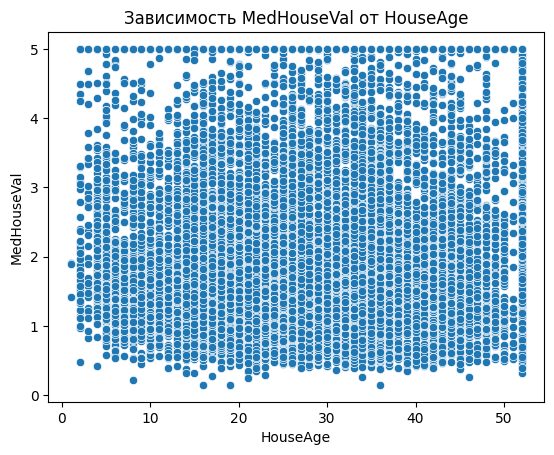

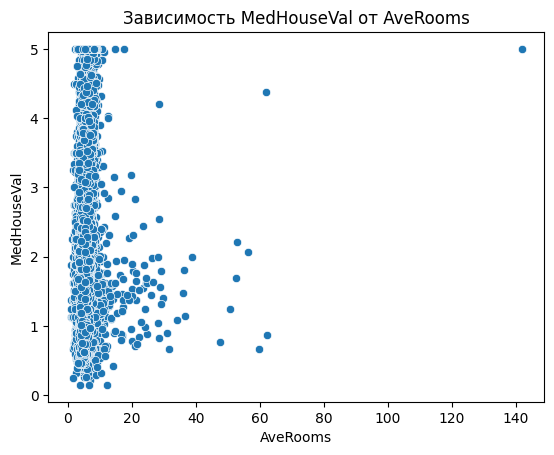

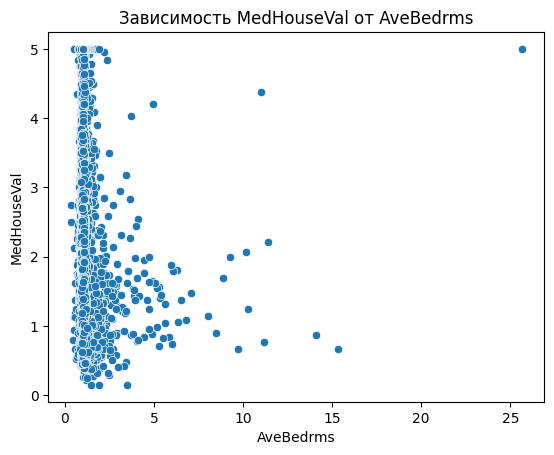

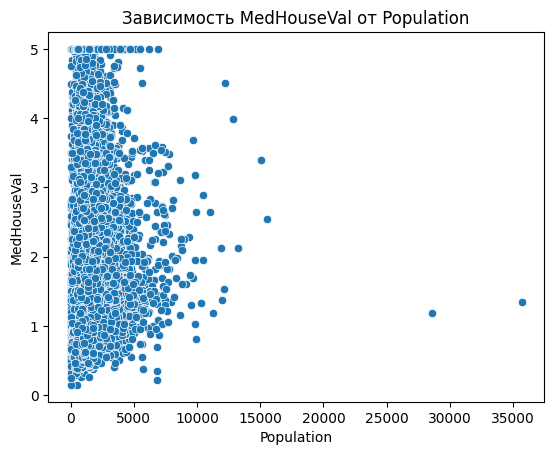

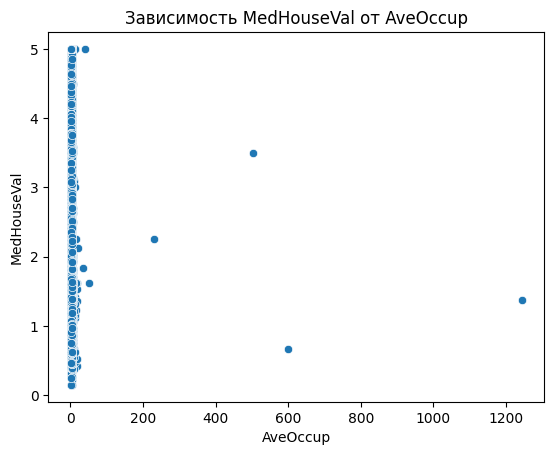

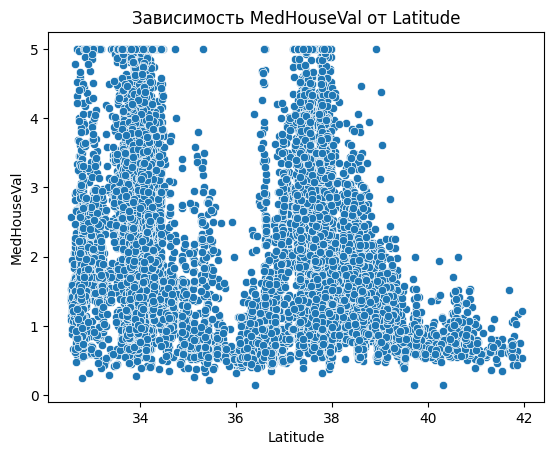

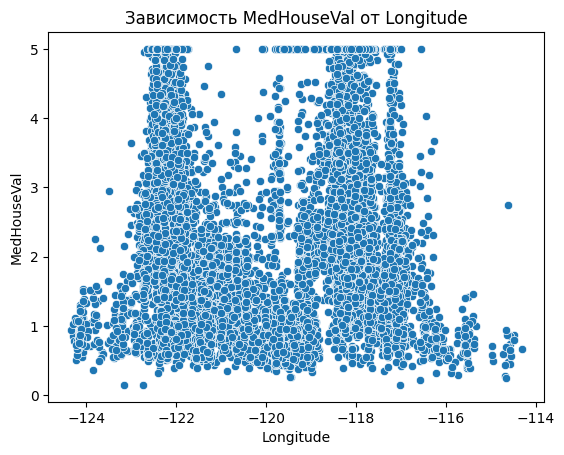

In [62]:
for column in X.columns:
    sns.scatterplot(data=df, x=column, y='MedHouseVal')
    plt.title(f'Зависимость MedHouseVal от {column}')
    plt.show()

#### Взаимосвязь между придикторами

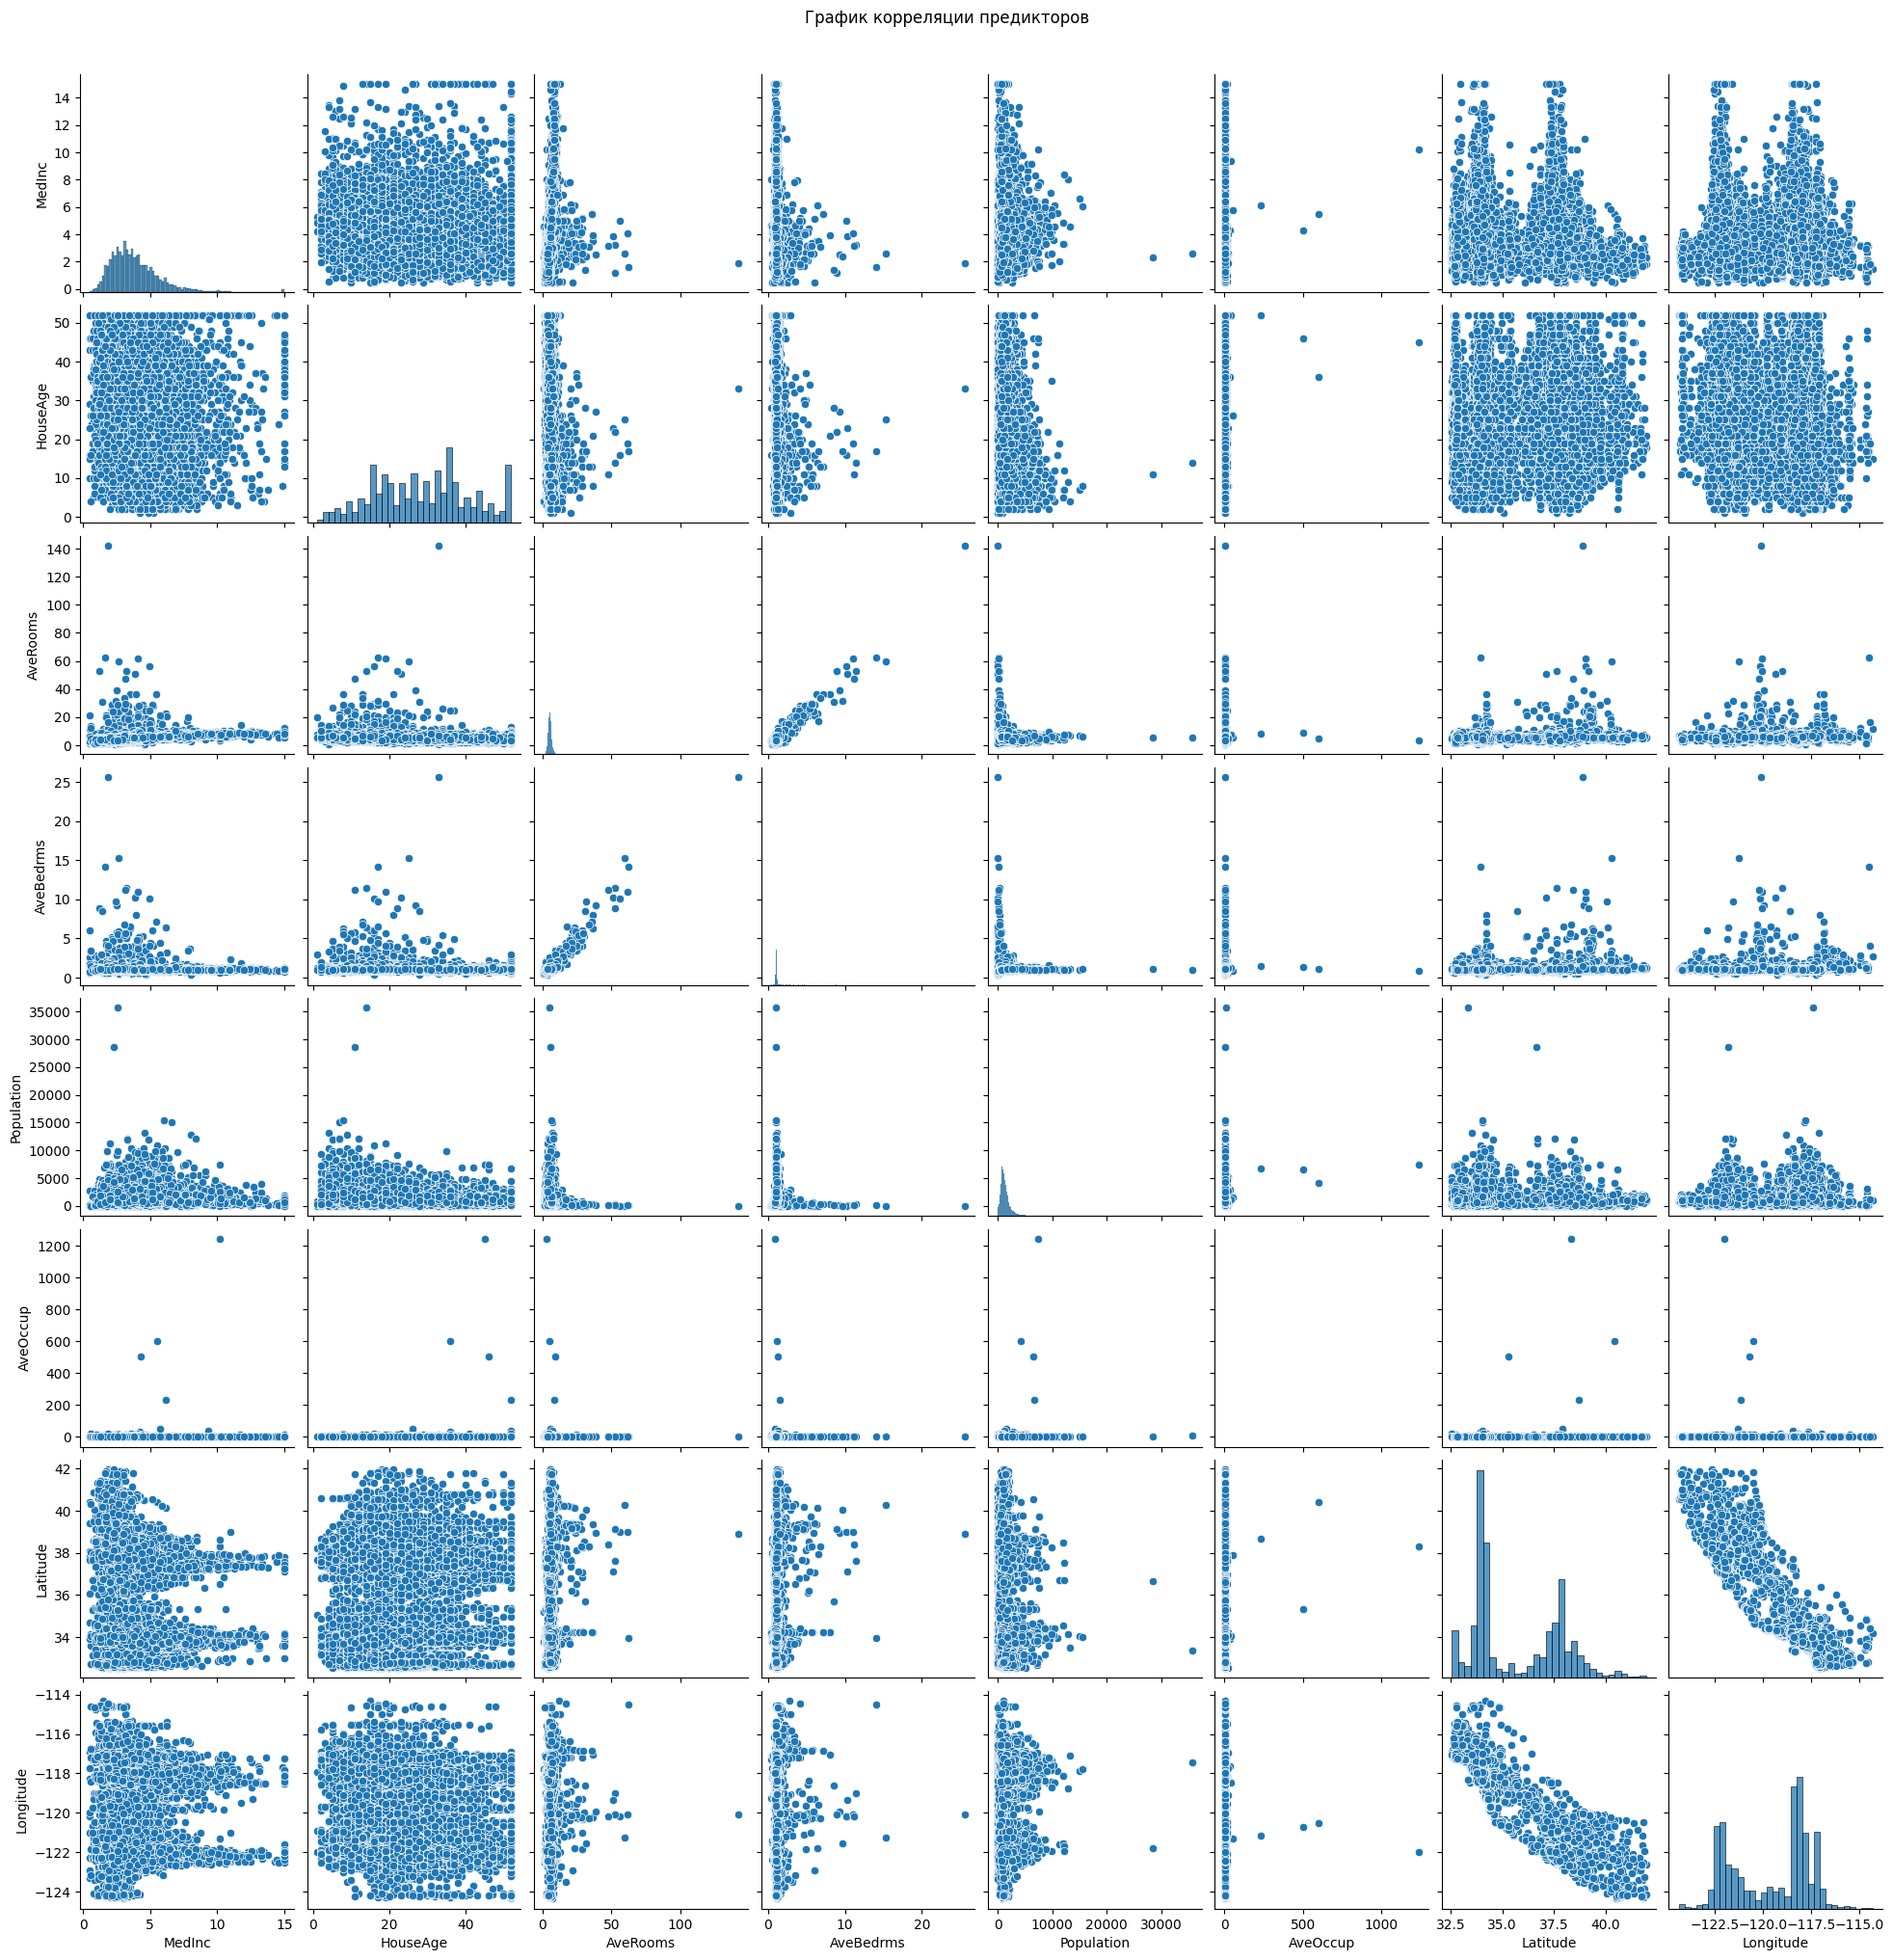

In [67]:
pair_plot = sns.pairplot(X_train)
pair_plot.figure.suptitle("График корреляции предикторов", y=1.02) 
plt.show()

#### Вывод:

1) Можем заменить что в основном наши предикторы нелинейно взаимосвязаны с нашей целевой переменой => линейные модели не будем брать
2) Наши предикторы тоже по разному взаимосвязаны между собой, но так как линейные модели мы не берем, то понятие мультиколлинеарности учитывать не будем
3) Так как по заданию мы не применяем нормализацию данных, то модели основаные на расстоянии между объектами данных мы тоже не будем применять

Исходя из этих условий:

| Тип модели                                            | Почему подходит                                                                                          |
| ----------------------------------------------------- | -------------------------------------------------------------------------------------------------------- |
| **Decision Tree Regressor**                           | Работает с нелинейными зависимостями, не требует нормализации, не чувствителен к коррелирующим признакам |
| **Random Forest Regressor**                           | Ансамбль деревьев, устойчив к шуму, автоматическая работа с нелинейностями                               |
| **Gradient Boosting (XGBoost / LightGBM / CatBoost)** | Эффективно обучает сложные нелинейные зависимости, не требует нормализации                               |
| **Neural Network (MLPRegressor)**                     | Теоретически подходит для нелинейных зависимостей, но без нормализации может обучаться медленнее         |


Мы возьмем CatBoostRegressor

Теперь определимся с метриками:

Так как у нас задача регрессии то метрики мы берем соответствующие

| Метрика                                              | Описание                                                                                                                                                 |
| ---------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **MAE (Mean Absolute Error)**                        | Средняя абсолютная ошибка. Показывает среднюю величину отклонения предсказаний от истинных значений в тех же единицах, что и целевая переменная.         |
| **MSE (Mean Squared Error)**                         | Среднеквадратичная ошибка. Учитывает квадраты отклонений, поэтому крупные ошибки влияют сильнее.                                                         |
| **RMSE (Root Mean Squared Error)**                   | Корень из MSE. Единицы измерения совпадают с целевой переменной, чувствителен к большим ошибкам.                                                         |
| **R² (Коэффициент детерминации)**                    | Доля дисперсии целевой переменной, объяснённая моделью. Показывает, насколько модель лучше среднего.                                                     |
| **MAPE (Mean Absolute Percentage Error)**            | Средняя абсолютная ошибка в процентах относительно истинных значений. Удобно для интерпретации в процентах, но плохо работает при нулях.                 |
| **sMAPE (Symmetric Mean Absolute Percentage Error)** | Симметричная средняя процентная ошибка. Ошибка нормируется на среднее между предсказанием и истинным значением, устойчива к нулям и маленьким значениям. |


Мы возьмем R² чтобы понять долю объясненной дисперсии, RMSE чтобы понять отклонение от наших истинных меток, но единцы измерения будут совпадать с целевой переменной, и также возьмем MAPE, чтобы понять среднюю абсолютную ошибку в процентах относительно истинных значений

In [72]:
model = CatBoostRegressor(verbose=0, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

R²: 0.8517
RMSE: 0.4412
MAPE: 16.71%


R² = 0.8517

Модель объясняет ~85% дисперсии целевой переменной.

Это очень хороший результат для регрессии на реальных данных.

RMSE = 0.4412

Среднеквадратичное отклонение предсказаний составляет 0.44 (в тех же единицах, что и MedHouseVal, т.е. сотни тысяч долларов).

То есть, в среднем, предсказание отличается от реального значения на ~44 000 долларов.

MAPE = 16.71%

Средняя ошибка предсказаний составляет ~16.7% от истинного значения.

Это значит, что в среднем прогноз отличается от реальной стоимости на ~17%, что тоже достаточно неплохо.

### При помощи библиотеки optuna сгенерируйте функционал по подбору гиперпараметров выбранной модели. Сформируйте сетку гиперпараметров, а также запустите обучение.

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10)
    }
    
    model = CatBoostRegressor(**params, random_state=42, verbose=0)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

best_params = study.best_params
print("Лучшие гиперпараметры:", best_params)

[I 2025-10-11 00:24:52,188] A new study created in memory with name: no-name-7b4ca4d7-0f8a-4092-8f46-ddcdd1fd101e
/var/folders/4m/n9xjjgns0d3g3fv4nnp_9zz40000gn/T/ipykernel_73894/3683065805.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/4m/n9xjjgns0d3g3fv4nnp_9zz40000gn/T/ipykernel_73894/3683065805.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
[I 2025-10-11 00:24:55,504] Trial 0 finished with value: 0.23084173024052684 and parameters: {'iterations': 749, 'depth': 10, 'learning_rate': 0.011762523432516641, 'l2_le

Лучшие гиперпараметры: {'iterations': 915, 'depth': 7, 'learning_rate': 0.09517867684895376, 'l2_leaf_reg': 4.812416580466563}


### Получите предсказание на обученной модели.

In [ ]:
best_model = CatBoostRegressor(
    iterations=best_params['iterations'],
    depth=best_params['depth'],
    learning_rate=best_params['learning_rate'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    random_state=42,
    verbose=0
)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

R²: 0.8584
RMSE: 0.4311
MAPE: 16.16%


In [80]:
y_pred.tolist()

[0.5449042155420671,
 0.7827938460856501,
 5.304599142694416,
 2.427099676569538,
 2.6817102590358366,
 1.634842852020081,
 2.2497867808649072,
 1.5714220238404368,
 2.782981454538423,
 4.954247722587929,
 1.0098553718588805,
 2.1915430663920445,
 1.6720410349466637,
 1.7913654348478691,
 2.51617995082427,
 1.6581879790085368,
 1.9108023930034963,
 1.5774431688499084,
 1.426852907170178,
 0.9765453676978477,
 3.8476112772596753,
 4.16486115374888,
 1.0707438516842975,
 4.149929373606396,
 1.73337180794028,
 0.48414177445074746,
 1.8906968910757342,
 1.0574774249435774,
 1.7194751832362185,
 3.6522289220577706,
 0.9970520212047753,
 1.0562934601573803,
 2.249272282255731,
 3.7744441018481725,
 2.6390992334474337,
 2.3415484174046504,
 3.146291380503812,
 1.5842507099737264,
 1.4663039233791924,
 1.3770828542950784,
 3.112561383426636,
 0.9658707691373276,
 1.0713326196050357,
 2.0270343620253115,
 1.4848440922451744,
 1.9040476354400875,
 1.3372941446254525,
 1.77937472409075,
 2.775759

### Постройте графики остатков (Predicted vs Actual Plot и Residuals vs Predicted Plot) для предсказанных данных и истинных значений. Попробуйте проинтерпритировать полученные результаты.

1) **Predicted vs Actual (Предсказанные vs Истинные)**
- Построение

X → истинные значения (y_test)

Y → предсказанные значения (y_pred)

Дополнительно добавляется линия y = x (идеальные предсказания).

- Что показывает

Точность модели: насколько предсказания близки к реальным значениям.

Систематические смещения:

Если точки в основном ниже линии y = x → модель недооценивает значения.

Если точки выше линии → модель переоценивает значения.

Диапазоны, где модель хуже справляется:

Например, для очень больших или маленьких значений цены дома могут появляться большие расхождения.

- Как интерпретировать

Идеально → все точки лежат на линии y = x.

Разброс вокруг линии → предсказания в среднем точные, но есть шум.

Систематический тренд → модель имеет bias (смещение), надо улучшать или менять гиперпараметры.

1) **Residuals vs Predicted (Остатки vs Предсказанные)**
- Построение

X → предсказанные значения (y_pred)

Y → остатки (residuals = y_true - y_pred)

Добавляется линия y = 0, которая обозначает идеальные предсказания без ошибок.

- Что показывает

Случайность ошибок:

Остатки должны быть распределены случайно вокруг нуля, без видимых трендов.

Гетероскедастичность:

Если дисперсия ошибок растёт с увеличением предсказанных значений → модель хуже предсказывает большие значения.

Выбросы и аномалии:

Очень большие остатки → точки с сильной ошибкой, которые могут влиять на качество модели.

- Как интерпретировать

Идеально → остатки случайны и равномерно распределены вокруг нуля.

Тренд или форма “вентилятора” → модель систематически недооценивает или переоценивает в определённом диапазоне.

Сильные выбросы → возможно шумные данные или редкие аномальные наблюдения.

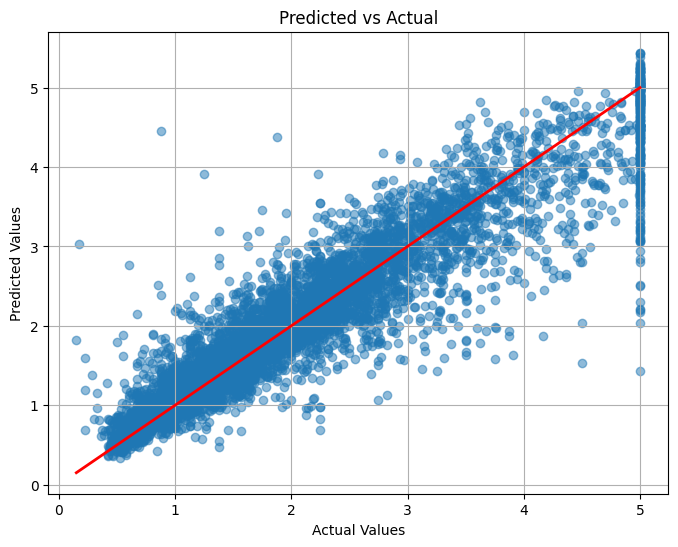

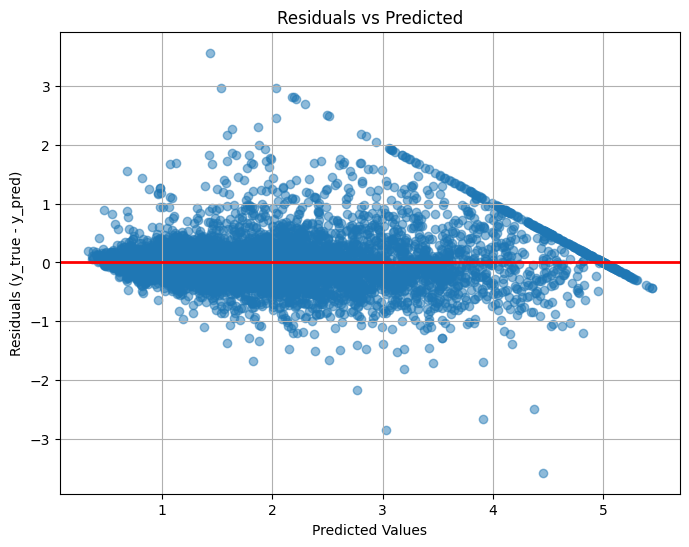

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (y_true - y_pred)')
plt.title('Residuals vs Predicted')
plt.grid(True)
plt.show()

По двум графикам можно сделать вывод: предсказания в среднем точные, но есть шум. Заметны большие отклонения в целевой цене 500000$. Для очень больших значений цены дома могут появляться большие расхождения. Из за этого в графике остатков мы можем увидеть линейный тренд

## Доп задание

Как не трудно заметить, функцию `objective` в `optuna` приходится менять каждый раз, как мы выбираем новую модель или новые данные. Например, для решения задачи мы хотим построить 3 разные модели, чтобы выбрать среди них лучшую. Но получается так, что надо трижды определять функцию `objective`, поскольку в ней зашита сетка гиперпараметров.

Или мы хотелим сравнить качество одной модели, обученной на двух датасетах: с применением скалирования и без.

И было бы здорово, если бы у нас был функционал по генерации функций objective. Достаточно в него передать класс модели, сетку и обучающие данные, и вернется нужная функция, которую можно использовать для оптимизации.

Задача: разработать функционал по генерации функции `objective` в зависимости от параметров обучения

Допустим, я выбрал модель CatBoostRegressor с сеткой `catboost_grid`, которую хочу обучить на данных `X_train_std` и `y_train`, эти параметры я передаю в функцию `gen_objective`:

In [ ]:
'''
def gen_objective(estimator_class, grid, X_train, y_train, **kwargs):
  ...
  def objective(trial):
    ...

  return objective
'''

которая возвращает функцию, что используется при подборе гиперпараметров.

In [ ]:
def gen_objective(estimator_class, grid, X_train, y_train, **kwargs):

    grid 
    def objective(trial):
        return ...
    
    return objective

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10)
    }
    
    model = CatBoostRegressor(**params, random_state=42, verbose=0)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

best_params = study.best_params
print("Лучшие гиперпараметры:", best_params)